In [23]:
import numpy as np
from scipy.ndimage import binary_erosion, binary_opening
from skimage.io import imread, imsave
from skimage import img_as_float32, img_as_ubyte
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.fftpack import fft

img = img_as_float32(imread('baseline.jpg', as_gray=True))

# imsave('skeleton.png', skeleton)


In [4]:
def skeletonize(Bb):
    skeleton = np.zeros_like(Bb, dtype=np.uint8)
    while Bb.max()>0:
        o = binary_opening(Bb)
        skeleton = skeleton | (Bb & 1-o)
        Bb = binary_erosion(Bb)
    return skeleton
Bb = (img > 0.2) * 1
skeleton=skeletonize(Bb)

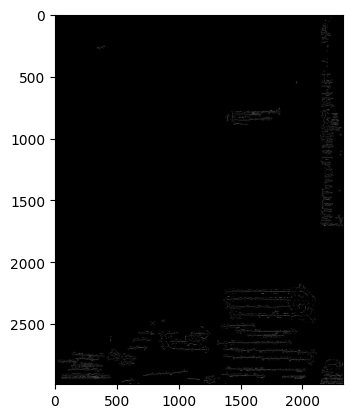

In [241]:
plt.imshow(skeleton, cmap='gray')

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 25

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_35136/1567029589.py:38: UserWarning: superpixels.png is a low contrast image
  imsave('superpixels.png', selected_mask)


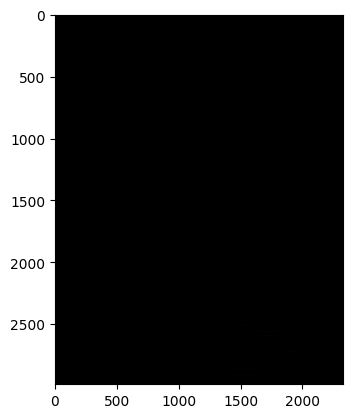

In [78]:
import cv2 
import time
from scipy.sparse import csr_matrix
from skimage import img_as_float

# baseline probs
baselines = np.copy(img)
baselines = img_as_float32(baselines)
sorted_intensity_indexes = np.argsort(baselines.ravel())[::-1]
selected_mask = np.zeros_like(skeleton, dtype=np.uint8)
superpixels = []
for i, index in enumerate(sorted_intensity_indexes):
    # Convert the flattened index to 2D indices
    i, j = np.unravel_index(index, baselines.shape)

    if not skeleton[i,j]:
        continue

    if baselines[i,j] < 0.2:
        break

    # Keeping number of superpixels small
    a = np.array((i,j))
    isValid = (np.array([np.linalg.norm(a-b) for b in superpixels]) >= 10).all()
    if isValid:
        selected_mask[i, j] = 255
        superpixels.append(a)

# print(selected_mask[selected_mask != 0])
plt.imshow(selected_mask, cmap='gray')
imsave('superpixels.png', selected_mask)

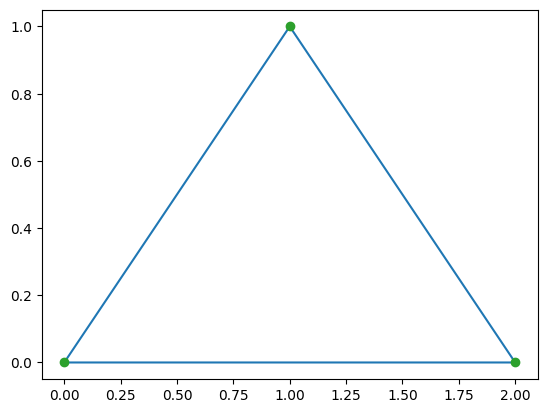

0
[2 1]


In [151]:
from scipy.spatial import Delaunay
from itertools import combinations


# Example set of point coordinates
points = np.array([[0, 0], [1, 1], [2, 0]])


# Compute the Delaunay triangulation
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

# Example point of interest

point_of_interest = points.tolist().index([0,0])
print(point_of_interest)

def find_neighbors(vertex_id, tri):
        pointer_to_vertex_neighbors, neighbors = tri.vertex_neighbor_vertices
        result_ids = neighbors[pointer_to_vertex_neighbors[vertex_id]:pointer_to_vertex_neighbors[vertex_id + 1]]
        return result_ids

print(find_neighbors(point_of_interest, tri))


In [13]:
def select_superpixels(B, Bs):
    '''
    Filter superpixels in the image.

    Parameters
    ----------
    B : array_like
       Baseline probability image
    Bs : array_like
       Skeletonized baseline image
    '''
    sorted_intensity_indexes = np.argsort(B.ravel())[::-1]
    superpixel_img = np.zeros_like(Bs, dtype=np.uint8)
    superpixels = []
    for index in sorted_intensity_indexes:
        # Convert the flattened index to 2D indices
        i, j = np.unravel_index(index, B.shape)

        if not Bs[i,j]:
            continue

        # If probability is worse than just a guess - pixel should not be part of baseline.
        # Further processing is not needed
        if B[i,j] < 0.2:
            break

        # mapping: i=y, j=x 
        a = np.array([i,j])
        # Keeping number of superpixels small
        isValid = (np.array([np.linalg.norm(a-b) for b in superpixels]) >= 10).all()
        if isValid:
            superpixel_img[i,j] = 255
            superpixels.append(a)
    return superpixels, superpixel_img

In [32]:
def compute_connectivity(e, I):
    '''
    Computes connectivity function - 
    the average intensity of image along the line segment `e`.

    Parameters
    ----------
    e : array_like
        e = (p, q), where p and q are arrays of coordinates of point p and q
    I : array_like
        Input image
    '''
    p, q = e

    segment_vector = q - p
    # Discretize the integral
    num_points = int(np.linalg.norm(segment_vector))
    intensity_sum = 0
    for t in range(num_points):
        point = np.round(p + t/num_points * segment_vector).astype(int)
        intensity_sum += I[point[0], point[1]]
    return intensity_sum/num_points

def get_point_neighbors(N, p):
    pointList = N.points.tolist()
    if not isinstance(p, list):
        p = list(p)
    p_index = pointList.index(p)
    pointer_to_vertex_neighbors, neighbors = N.vertex_neighbor_vertices
    neighbor_vertices = neighbors[pointer_to_vertex_neighbors[p_index]: \
                                  pointer_to_vertex_neighbors[p_index + 1]]
    nv_coords = [N.points[q] for q in neighbor_vertices]
    return nv_coords

def extract_lto(p, N, B):
    '''
    Extract local text orientation angle for each superpixel

    Parameters
    ----------
    p : list_like
        Superpixel coordinates
    T : object_like
        Delaunay tessellation object
    B : array_like
        The baseline prediction image B
    '''
    nv_coords = get_point_neighbors(N, p)
    M = [(np.array(p), q) for q in nv_coords]
    L = np.array([(e, compute_connectivity(e, B)) for e in M], dtype=object)
    # Sort by baseline connectivities.
    L = L[(-L[:,1]).argsort()]
    if len(L) == 1:
        e = L[0,0]
    else:
        # L[0,0] -> 0th neighbor of p (based on connectivity). Second index denotes
        # edge coordinate position. Next index (1) selects q or r coords that are not p.
        e = (L[0,0][1], L[1,0][1]) 
    return np.arctan(abs(e[1][0] - e[0][0])/(abs(e[1][1] - e[0][1])+ np.finfo(np.float64).eps))


In [8]:
def select_points_in_circle(a, points, radius):
    distances = np.linalg.norm(abs(points - a), axis=1)
    mask = distances <= radius
    points_within_circle = points[mask]
    return points_within_circle

def compute_projection_profile(points, angles, diameters):
    points = np.array(points)
    h_pd = []
    for id, p in enumerate(points):
        orientation_vector = np.array([np.cos(angles[id]), np.sin(angles[id])])
        h_d = []
        for dia in diameters:
            ps = select_points_in_circle(p, points, dia/2)
            pq = ps - p
            projections = np.dot(pq, orientation_vector)
            bin_indices = np.round(dia / 2 + projections).astype(int)
            counts = np.bincount(bin_indices, minlength=dia)
            h_d.append(np.array(counts))
        h_pd.append(np.array(h_d))
    return np.array(h_pd)


In [15]:
# Main code
B = img.copy()
Bb = (B > 0.2) * 1
print("running skeleton")
Bs = skeletonize(Bb)
print("running superpixels")
S, SI = select_superpixels(B, Bs)
print(len(S))
print("running delaunay")
N = Delaunay(S)
print("running lto")
angles = [extract_lto(p, N, B) for p in S]
ks = np.array([3,4,5])
ds = np.array([64, 128, 256, 512])
h = compute_projection_profile(S, angles, ds)



running skeleton
running superpixels
745
running delaunay
running lto


/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_59857/1691584964.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h_pd.append(np.array(h_d))


17


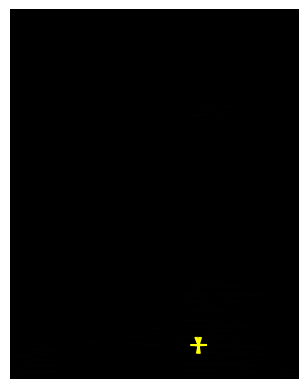

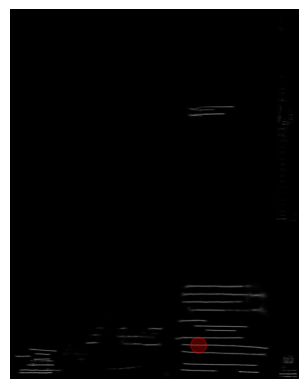

In [21]:
plt.imshow(SI, cmap='gray')
plt.axis("off")
p_idx = 300
x_S = S[p_idx][1]
y_S = S[p_idx][0]
q = select_points_in_circle(S[p_idx], np.array(S), 64)
print(len(q))
for i in range(len(q)):
    y_S2 = q[i][0]
    x_S2 = q[i][1]
    x = [x_S, x_S2]
    y = [y_S, y_S2]
    plt.plot(x,y, c='yellow')
fig, ax = plt.subplots()
ax.imshow(B, cmap='gray')
circle1 = plt.Circle((x_S, y_S), 64, color='r', alpha=.3)
ax.add_patch(circle1)
ax.axis('off')
plt.show()

In [680]:
# (point, (angle, random interline_distance))
states = [(p, (extract_lto(p, N, B), 64.0)) for p in S]

/var/folders/sb/bbw9n1955t7gjptn_zsz0z0r0000gn/T/ipykernel_59857/1691584964.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  h_pd.append(np.array(h_d))


(745, 4)


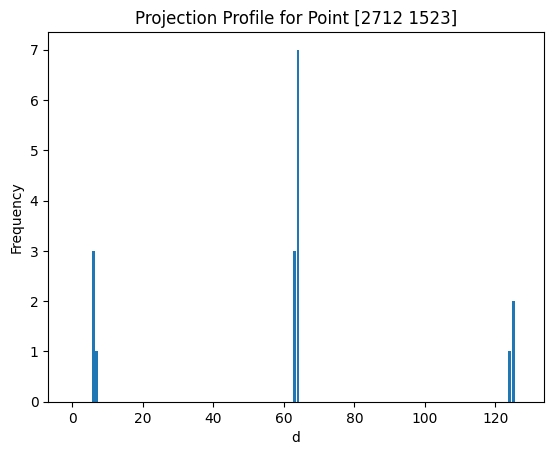

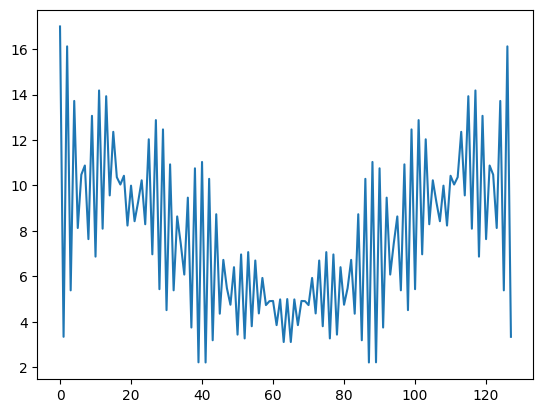

In [24]:
ks = np.array([3,4,5])
ds = np.array([64, 128, 256, 512])
h = compute_projection_profile(S, angles, ds)
print(h.shape)
# fft_arr = fft(np.array(h, dtype=np.int64))
fft_arr = []
for p in range(len(S)):
    fft_d = []
    for d in range(len(ds)):
        fft_d.append(fft(h[p,d]))
    fft_arr.append(fft_d)

plt.bar(range(len(h[300,1])), h[300,1])
plt.xlabel('d')
plt.ylabel('Frequency')
plt.title('Projection Profile for Point {}'.format(S[300]))
plt.show()



H = fft_arr[300][1] #fft(h[300,1])
plt.plot(np.abs(H))
plt.show()


In [199]:
def compute_data_energies(H_pd):
    E = {}
    for p_id in range(len(H_pd)):
        for d_id in range(len(ds)):
            H_pd_dist_sq = np.sum(np.abs(H_pd[p_id][d_id])**2)
            for k_id in range(len(ks)):
                # save energy for computed distance 
                s_p = np.round(ds[d_id]/ks[k_id])
                E[s_p] = np.abs(H_pd[p_id][d_id][k_id])**2/H_pd_dist_sq
    sorted_dict = {k: v for k, v in sorted(E.items(), reverse=True)}
    return sorted_dict

# def gen_all_interline_distances(ds, ks):
#     S_d = []
#     for d in ds:
#         for k in ks:
#             S_d.append([d/k, d, k])
#     S_d = -np.sort(-np.array(S_d[:,0]))
#     S_d = S_d.tolist()
#     return S_d

E_dict = compute_data_energies(fft_arr)

# def get_max_energy_distance(p, E_pdk):
#     p_idx = points.index(p)
#     energy_config_map = E_pdk[p_idx]
#     highest_energy_idx = np.argmax(energy_config_map.flatten())
#     d, k = np.unravel_index(highest_energy_idx, energy_config_map.shape)
#     return d/k, E_pdk[d, k]

def data_cost(s_p, alpha=1):
    E_s_p = E_dict[s_p]
    return alpha * (-np.log(E_s_p))

def get_pointlabel_mappings(dists, alpha, beta):
    label2graph = {}
    graph2label = {}
    graph_node = 0
    for p, (_, dist) in dists.items():
        if dist == alpha or dist == beta:
            graph2label[graph_node] = (p, dist)
            label2graph[p] = graph_node
            graph_node += 1
    return graph2label, label2graph

import maxflow as mf

def V_p_q(s_p, s_q, sigma=25):
    '''Definition of the potential'''
    keys = E_dict.keys()
    index1 = list(keys).index(s_p)
    index2 = list(keys).index(s_q)
    dist = abs(index2 - index1)
    return dist if dist < 4 else sigma

def alpha_beta_swap_new(dists, alpha, beta, N):
    print(alpha, beta)
    graph2label, label2graph = get_pointlabel_mappings(dists, alpha, beta)
    #extract position of alpha or beta interline distances
    graph_mf = mf.Graph[float](len(graph2label))
    nodes = graph_mf.add_nodes(len(graph2label))
    #add n-link edges
    weight = V_p_q(alpha, beta)
    for i in range(len(graph2label)):
        p, _ = graph2label[i]
        nv_nodes = get_point_neighbors(N, p)
        for nv_p in nv_nodes:
            nv_p_key = tuple(nv_p)
            if nv_p_key in label2graph:
                graph_mf.add_edge(i, label2graph[nv_p_key], weight, 0)
   
    #add all the terminal edges
    for i in range(len(graph2label)):
        p, _ = graph2label[i]
        #find neighbours
        nv_nodes = get_point_neighbors(N, p)
        fil_neigh = dict(filter(lambda el: np.any(np.all(np.array(nv_nodes) == el[0], axis=1)) and el[1][1] != alpha and el[1][1] != beta, dists.items()))
        #consider only neighbours which are not having alpha or beta label
        # fil_neigh = dict(filter(lambda nv: nv[1][1] != alpha and nv[1][1] != beta, nv_dists.items()))
        # print(fil_neigh)
        #calculation of weight
        t_weight_alpha = sum([V_p_q(alpha,v[1]) for _,v in fil_neigh.items()]) + data_cost(alpha)
        t_weight_beta = sum([V_p_q(beta,v[1]) for _,v in fil_neigh.items()]) + data_cost(beta)
        graph_mf.add_tedge(nodes[i], t_weight_alpha, t_weight_beta)

    #calculating flow
    graph_mf.maxflow()
    res = [graph_mf.get_segment(nodes[i]) for i in range(len(nodes))]
    
    #depending on cut assign new label
    for i in range(len(res)):
        p, _ = graph2label[i] 
        (angle, _) = dists[p]
        if res[i] == 1:
            dists[p] = (angle, alpha)
        else:
            dists[p] = (angle, beta)
    
    return dists

def swap_minimization(dist_states, cycles=1):
    '''This methods implements the energy minimization via alpha-beta-swaps
       img_orig: is original input image
       img_work: optimized image
       cycles: how often to iterate over all labels'''
    T = 0
    import time
    import itertools
    key_combinations = itertools.combinations(E_dict.keys(), 2)
    unique_pairs = set(key_combinations)
    #do iteration of all pairs a few times
    for u in range(0, cycles):
        #iterate over all pairs of labels 
        for pair in unique_pairs:
            start = np.round(time.time() * 1000)
            dist_states = alpha_beta_swap_new(dist_states, pair[0], pair[1], N)
            print('time', np.round(time.time()*1000) - start)
    return dist_states


In [161]:
import random
# (point, (angle, random interline_distance))

E_dict_keylist = list(E_dict.keys())
states = {tuple(p): (extract_lto(p, N, B), random.choice(E_dict_keylist)) for p in S}

In [193]:
print(E_dict_keylist)

[171.0, 128.0, 102.0, 85.0, 64.0, 51.0, 43.0, 32.0, 26.0, 21.0, 16.0, 13.0]


In [123]:
nv_nodes = get_point_neighbors(N, (2935, 314))
first_key = next(iter(states))
print(list(first_key))
print(nv_nodes[0])
# print(nv_nodes.shape)
print(np.array(first_key) in np.array(nv_nodes))
print(len(states))
print(nv_nodes)
print(np.array(first_key))
nv_dists = dict(filter(lambda el: np.any(np.all(np.array(nv_nodes) == el[0], axis=1)), states.items()))
print(len(nv_dists))
print(nv_dists)


print([2935, 314]in [[2935, 331]])

[2935, 314]
[2935.  331.]
True
745
[array([2935.,  331.]), array([2916.,  324.]), array([2936.,  341.]), array([2936.,  301.]), array([2915.,  309.])]
[2935  314]
5
{(2935, 331): (0.037020115873930025, 51.0), (2936, 301): (0.03844259002118799, 16.0), (2916, 324): (0.03844259002118799, 51.0), (2915, 309): (0.039978687123290044, 102.0), (2936, 341): (0.07677189126977804, 13.0)}
False


In [200]:
new_states = swap_minimization(states)
print(len(new_states))
print(new_states)

26.0 21.0
time 9053.0
21.0 16.0
time 8873.0
85.0 43.0
time 0.0
21.0 13.0
time 8876.0
128.0 26.0
time 0.0
171.0 128.0
time 0.0
128.0 32.0
time 0.0
102.0 13.0
time 0.0
64.0 32.0
time 0.0
171.0 64.0
time 1.0
102.0 16.0
time 0.0
85.0 64.0
time 0.0
64.0 26.0
time 0.0
51.0 13.0
time 0.0
128.0 102.0
time 0.0
51.0 16.0
time 0.0
171.0 21.0
time 9269.0
85.0 21.0
time 8880.0
171.0 85.0
time 0.0
43.0 21.0
time 8895.0
32.0 21.0
time 9515.0
102.0 43.0
time 0.0
16.0 13.0
time 0.0
128.0 13.0
time 0.0
64.0 13.0
time 0.0
128.0 16.0
time 1.0
171.0 51.0
time 0.0
51.0 43.0
time 0.0
85.0 51.0
time 0.0
64.0 16.0
time 0.0
102.0 64.0
time 0.0
128.0 43.0
time 0.0
102.0 21.0
time 9054.0
102.0 85.0
time 0.0
64.0 43.0
time 0.0
51.0 21.0
time 9063.0
171.0 26.0
time 0.0
171.0 32.0
time 0.0
85.0 26.0
time 0.0
85.0 32.0
time 0.0
26.0 13.0
time 0.0
171.0 102.0
time 0.0
43.0 26.0
time 0.0
128.0 64.0
time 1.0
102.0 51.0
time 0.0
43.0 32.0
time 0.0
32.0 26.0
time 0.0
26.0 16.0
time 0.0
128.0 21.0
time 9272.0
128.0 85.0
ti

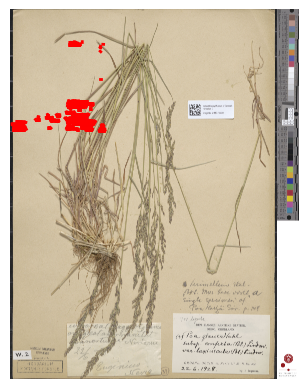

In [202]:
orig = img_as_float32(imread('orig.jpg'))
plt.imshow(orig)
plt.axis("off")
p_idx = 300
for k, (angle_rad, pixels) in new_states.items():
    angle_rad, pixels= new_states[k]
    start_point = k
    angle = np.rad2deg(angle_rad) + 90
    angle_rad = np.deg2rad(angle)

    # Calculate end point based on angle and number of pixels
    end_point = (int(start_point[0] + np.sin(angle_rad) * int(pixels)),
                int(start_point[1] - np.cos(angle_rad) * int(pixels)))

    # Draw line on image
    x = np.linspace(start_point[0], end_point[0], int(pixels))
    y = np.linspace(start_point[1], end_point[1], int(pixels))
    plt.plot(y, x,'r-', linewidth=2)

# Display image
plt.show()